<a href="https://colab.research.google.com/github/santifs/biomechatronics/blob/master/Kalman%20Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alumno: Santiago Fernández Scagliusi

# Filtro de Kalman


*Este documento es un cuaderno de jupyter/colab. En él deberá añadir la información solicitada en las celdas a continuación de los textos escritos en rojo. Recuerde ejecutar cada celda para poder ver sus resultados (o cargar sus variables)*

*El código escrito deberá estar convenientemente comentado*

*Dado que algunas variables se usan en distintos puntos de la práctica, se recomienda usar nombres de variables distintos para cada etapa (h, h1, h2, h3, ...) para evitar sobreescribir una variable que pueda ser necesaria más adelante.*



En el siguiente fichero vamos a ver como se ejecuta un filtro de kalman.

## Preparando el entorno

Estas son las librerías usadas en este cuaderno así como la configuración del mismo para que los gráficos se muestren adecuadamente.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generando los datos

Con el fin de poder evaluar la calidad del filtro, vamos a generar primero el comportamiento de nuestro sistema real (que además suponemos ideal) y posteriormente vamos a añadirle un ruido gausiano para simular el error en las medidas.

Parámetros para definir nuestro experimento: 
* tiempo de prueba, 
* Estado inicial (posición y velocidad inicial),
* Desviación estándar del error en las medidas

In [81]:
t_max = 150
x_0 = np.array([1,1.5])
error_std = np.array([5,0.2])

Cálculo de las medidas de los sensores. `x_real` es el óptimo o valor real y `x_medido` es el estado proporcionado por los sensores con sus errores. 

In [82]:
t = np.array(range(t_max))
x_real = np.column_stack(([ [1, it] for it in t ] @ x_0, [ 1 for it in t]))
x_medido = x_real + np.column_stack((np.random.normal(0,error_std[0],t_max),np.random.normal(0,error_std[1],t_max)))

Visualizando los datos reales y los valores proporcionados por los sensores.

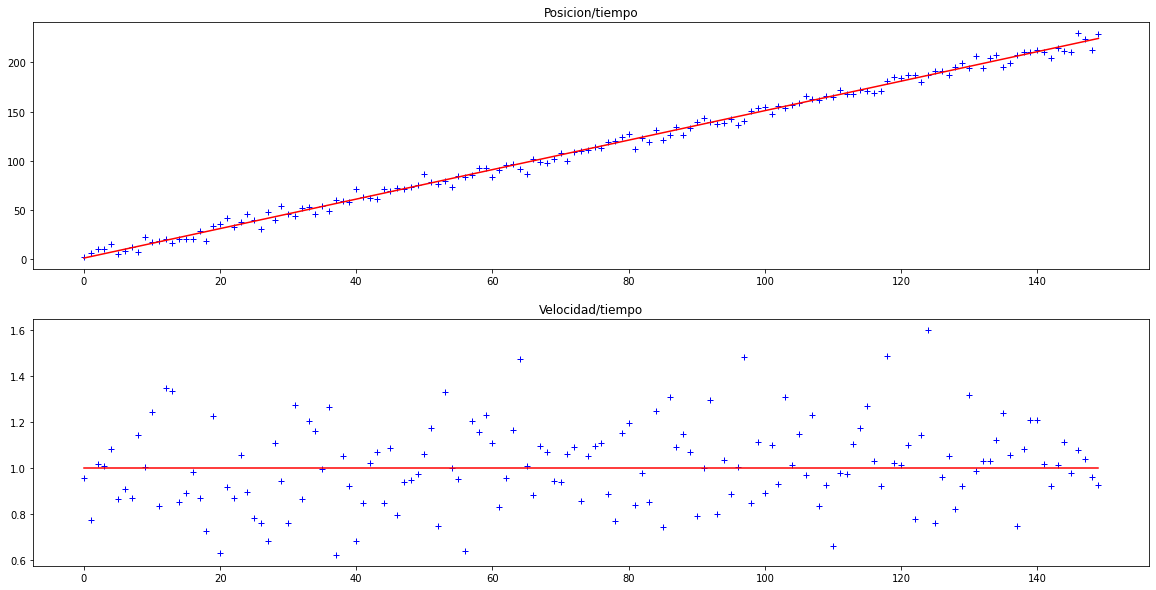

In [83]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(t,x_medido[:,0],'+b',t,x_real[:,0],'r')
plt.title('Posicion/tiempo')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t,x_medido[:,1],'+b',t,x_real[:,1],'r')
plt.title('Velocidad/tiempo');

## Definición del motor de ejecución del filtro de Kalman

Todos los filtros de Kalman se ejecutan de igual forma, independientemente del los datos con los que se estén trabajando. Por ello, en la mayoría de los casos, la ejecución del filtro está dividido en dos bloques: por un lado está la ejecución del filtro en sí, un ciclo y por otro lado está la configuración de las matrices para especificar el modelo del sistema con el que se va a trabajar.

El motor empleado es una variación del disponible en https://github.com/zziz/kalman-filter.

Existen dos observaciones al motor mostrado:
* Presupone que la señal de control externa es un escalar. Ese límite está impuesto por el código y no es una restricción de los filtros de Kalman.
* Presupone, en la actualización, que los efectos cruzados entre las variables de estado son nulos. Esto es, el valor de una variable (la velocidad) no alterará la actualización de otra (o dicho de otro modo, cuando se actualice el valor de la posición, esta solo dependerá de la posición del modelo y de la posición medida del sensor, pero no de la velocidad medida o predicha).

Una ilustración de estos aspectos puede encontrarse en https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/

In [84]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):
        """ Función de inicialización del filtro. En él se definen las variables 
        definen el comportamiento del filtro. Si una variable no es definida en
        en la inicialización (y por tanto toma el valor por defecto "None"), esta 
        se inicializará como una matriz de ceros y por tanto no tendrá efecto en la
        ejecución del filtro 
        
        Nota sobre Python. Las variables F, B, H... son externas al objeto
        es necesaria copiarlas a variables internas que se conservan entre llamadas.
        Estas son self.F, self.B, self.H, ... self."Algo" debe leerse como variable
        "Algo" interna."""

        #"Las matrices F y H son obligatorias"
        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        #"Dimensiones de las matrices: Tamaño de las variables del sistema y variables observadas"
        self.n = F.shape[1]
        self.m = H.shape[1]

        #"Copiando a variables internas considerando si están definidas o no."
        self.F = F
        self.H = H
        self.B = np.zeros((self.n, 1)) if B is None else B
        self.Q = np.zeros((self.n, self.n)) if Q is None else Q
        self.R = np.zeros((self.n, self.n)) if R is None else R
        self.P = np.zeros((self.n, self.n)) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0
        
    def predict(self, u = 0):
        """ Predicción del modelo función de las variables del sistema "x" y 
        la señal de control "u" """
        self.x = self.F @ self.x + self.B * u
        self.P = self.F @ self.P @ self.F.T + self.Q
        
        return self.x

    def kept_diag(K):
        """ Elimina todos los valores fuera de la diagonal principal """
        output = np.zeros_like(K)
        np.fill_diagonal(output,np.diag(K))
        return output
    
    def update(self, z):
        """ Actualiza el valor de la predicción en función de las lecturas de 
        los sensores """
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P @ self.H.T
        K = self.P @ self.H.T @ np.linalg.inv(S)
        K = KalmanFilter.kept_diag(K)
        self.x = self.x + K @ y
        I = np.eye(self.n)      
        self.P = (I - K @ self.H) @ self.P

## Ejemplo de aplicación del filtro de Kalman sobre los datos anteriormente generados.

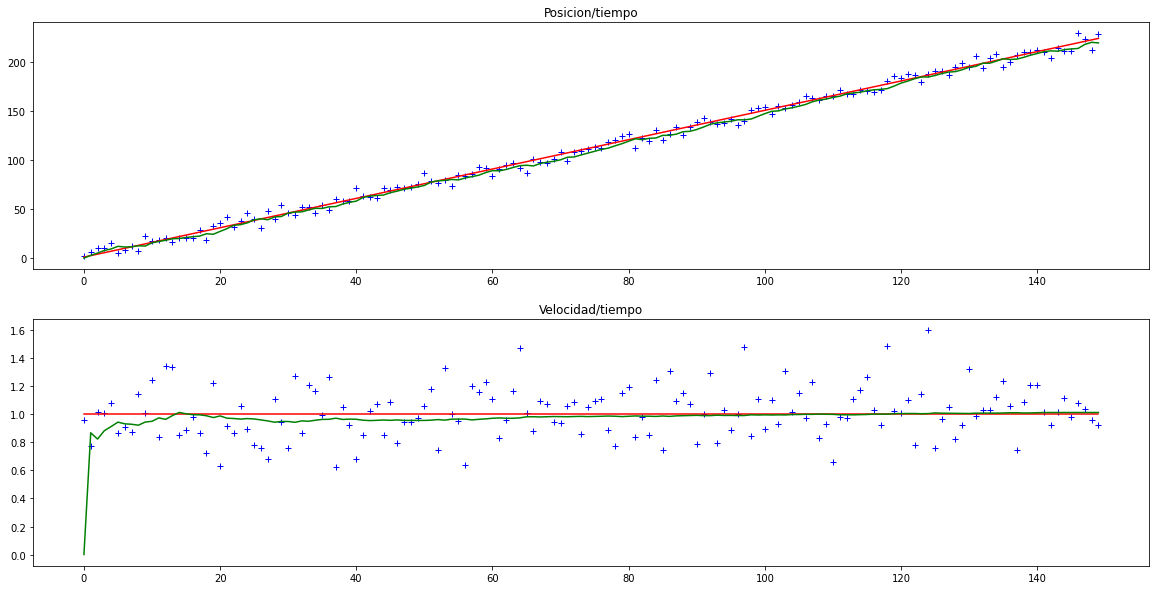

In [85]:
# Paso del tiempo
dt = 1.0
# Modelo del sistema definido en las matrices
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0],[0,1]])
Q = np.diagflat([0.,0.])
P = np.diagflat([100.,2.])
R = np.diagflat(error_std)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions = np.empty([t_max,2])

# Simulación de la lectura de los sensores
for it, z in enumerate(x_medido):
    x_hat = (H @ kf.predict()).T
    predictions[it,:] = x_hat
    kf.update(np.array(z).reshape(-1,1))

# Mostrando resultados
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(t,x_medido[:,0],'+b',t,x_real[:,0],'r',t,predictions[:,0],'g')
plt.title('Posicion/tiempo')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t,x_medido[:,1],'+b',t,x_real[:,1],'r',t,predictions[:,1],'g')
plt.title('Velocidad/tiempo');

## Tareas

### Interpretación

<font color="red">Interprete las gráficas anteriores indicando las relaciones entre la línea verde (¿Qué es? y ¿Por qué tiene ese comportamiento?) y los otros elementos de la graficas.</font>

Los puntos azules son las medidas, la línea roja es el valor ideal y la línea verde es la aproximación del filtro de Kalman.

Al principio la aproximación presenta un error mayor debido a que las predicciones consideradas están lejos del valor real. Con cada iteración, si las matrices están bien configuradas, el resultado del filtro de Kalman se irá acercando cada vez más al valor ideal.

### Inclusión de aceleración en el modelo

El modelo mostrado en el ejemplo, representa un objeto con movimiento a velocidad constante. Modifique el sistema dado de ejemplo para que incluya en el modelo una aceleración constante.

Considere las siguientes condiciones: 

*   Posición inicial: 0 m
*   Velocidad inicial: 10 m/s
*   aceleración: -1 m/s^2
*   simulación hasta la detención del objeto
*   incremento temporal para la simulación 0.1 s



<font color="red">Generación de los datos del modelo con ruido</font>

In [86]:
v2 = 10 # Velocidad inicial (m/s)
a2 = -1 # Aceleracion constante (m/s^2)
t_max2 = int((0-v2)/a2) # Tiempo maximo pasado a entero para evitar error (= 10)
x_02 = 0  # Posicion inicial
error_std2 = np.array([10,0.5,0.05]) # Valores tomados aleatoriamente

t2 = np.array(np.arange(0,t_max2,0.1))  # Incremento temporal de 0.1s (range no soporta valores decimales, np.arange sí)
x_real2 = np.column_stack(([ [x_02 + v2*it - 1/2*a2*it**2] for it in t2 ], [[v2 + a2*it] for it in t2], [a2 for it in t2])) # Ecuaciones de un MRUA
x_medido2 = x_real2 + np.column_stack((np.random.normal(0,error_std2[0],t_max2*10),np.random.normal(0,error_std2[1],t_max2*10),np.random.normal(0,error_std2[2],t_max2*10)))

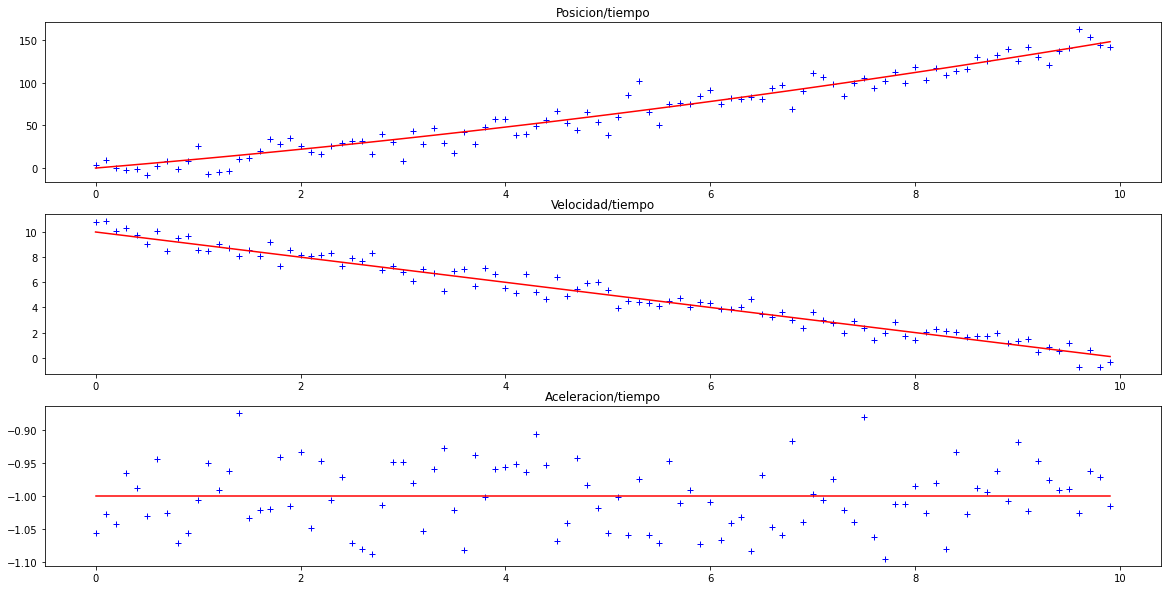

In [87]:
# Representacion de valores medidos y reales

plt.figure(figsize=(20,10))
ax1=plt.subplot(3, 1, 1)
ax1.plot(t2,x_medido2[:,0],'+b',t2,x_real2[:,0],'r')
plt.title('Posicion/tiempo')
ax2=plt.subplot(3, 1, 2)
ax2.plot(t2,x_medido2[:,1],'+b',t2,x_real2[:,1],'r')
plt.title('Velocidad/tiempo');
ax3=plt.subplot(3, 1, 3)
ax3.plot(t2,x_medido2[:,2],'+b',t2,x_real2[:,2],'r')
plt.title('Aceleracion/tiempo');

<font color="red">Generación del modelo y aplicación del filtro</font>

In [88]:
# Paso del tiempo
dt = 0.1
# Modelo del sistema definido en las matrices
F = np.array([[1, dt, (dt/2)**2], [0, 1, dt], [0, 0, 1]]) # Ahora incluye la aceleración
H = np.array([[1, 0, 0],[0,1,0],[0,0,1]]) # Se aumenta la dimension debido a la aceleracion
Q = np.diagflat([0.,0.,0.])
P = np.diagflat([100.,2.,1.])
R = np.diagflat(error_std2)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions = np.empty([t_max2*10,3])

# Simulación de la lectura de los sensores
for it, z, in enumerate(x_medido2):
    x_hat = (H @ kf.predict()).T
    predictions[it,:] = x_hat
    kf.update(np.array(z).reshape(-1,1))



<font color="red">Representación de los resultados aquí</font>

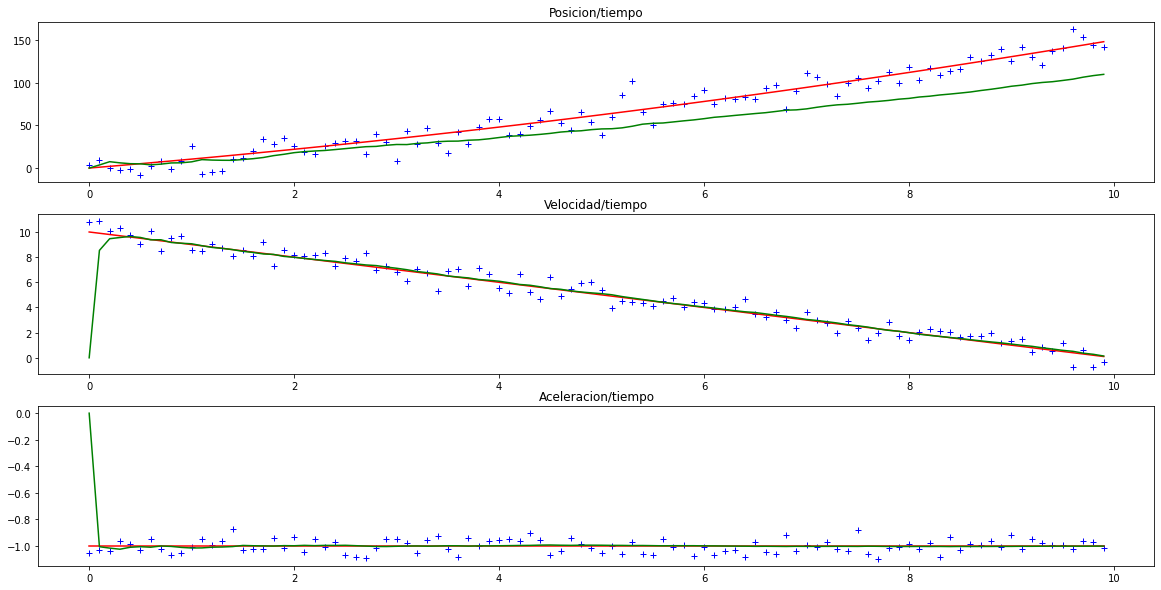

In [89]:
# Representacion de los valores medidos, los reales y las predicciones
plt.figure(figsize=(20,10))
ax1=plt.subplot(3, 1, 1)
ax1.plot(t2,x_medido2[:,0],'+b',t2,x_real2[:,0],'r',t2,predictions[:,0],'g')
plt.title('Posicion/tiempo')
ax2=plt.subplot(3, 1, 2)
ax2.plot(t2,x_medido2[:,1],'+b',t2,x_real2[:,1],'r',t2,predictions[:,1],'g')
plt.title('Velocidad/tiempo');
ax3=plt.subplot(3, 1, 3)
ax3.plot(t2,x_medido2[:,2],'+b',t2,x_real2[:,2],'r',t2,predictions[:,2],'g')
plt.title('Aceleracion/tiempo');

### Modelo con movimiento en 2 dimensiones

El modelo mostrado en el ejemplo, representa un objeto con movimiento a velocidad constante sobre una dimensión. Modifique el sistema dado de ejemplo para que incluya en el modelo velocidad constante en dos dimensiones.

Considere las siguientes condiciones: 

*   Posición inicial: (0,0) m
*   Velocidad inicial: (3,5) m/s
*   simulación hasta 10 segundos
*   incremento temporal para la simulación 0.1 s



<font color="red">Generación de los datos del modelo con ruido</font>

In [90]:
# Para este apartado se separaran las magnitudes en eje X e Y, y se resolveran con matrices como en el ejemplo inicial

v3x = 3.5 # Velocidad (m/s)
v3y = 3.5
t_max3 = 10 # Tiempo (s)
x_03x = np.array([0,3.5]) # Posicion (m)
x_03y = np.array([0,3.5])
error_std3x = np.array([2,0.5])
error_std3y = np.array([2,0.5])

t3 = np.array(np.arange(0,t_max3,0.1))  # Incremento temporal de 0.1s (range no soporta valores decimales, np.arange sí)
x_real3x = np.column_stack(([ [1, it] for it in t3 ] @ x_03x, [ v3x for it in t3]))
x_real3y = np.column_stack(([ [1, it] for it in t3 ] @ x_03y, [ v3y for it in t3]))
x_medido3x = x_real3x + np.column_stack((np.random.normal(0,error_std3x[0],t_max3*10),np.random.normal(0,error_std3x[1],t_max3*10)))
x_medido3y = x_real3y + np.column_stack((np.random.normal(0,error_std3y[0],t_max3*10),np.random.normal(0,error_std3y[1],t_max3*10)))

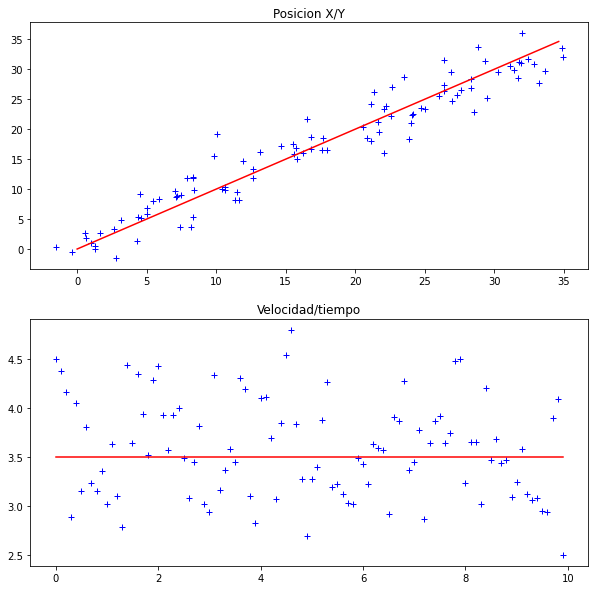

In [91]:
# Posicion eje X respecto a eje Y
# Velocidad frente al tiempo (si fuera entre ejes seria un único punto en 3.5-3.5)

plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(x_medido3x[:,0],x_medido3y[:,0],'+b',x_real3x[:,0],x_real3y[:,0],'r')
plt.title('Posicion X/Y')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t3,x_medido3y[:,1],'+b',t3,x_real3y[:,1],'r')
plt.title('Velocidad/tiempo');

<font color="red">Generación del modelo y aplicación del filtro</font>

In [92]:
# Se aplica un filtro para cada eje

# Paso del tiempo
dt = 0.1
# Modelo del sistema definido en las matrices
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0],[0,1]])
Q = np.diagflat([0.,0.])
P = np.diagflat([100.,4.])
R = np.diagflat(error_std3x)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions3x = np.empty([t_max3*10,2])

# Simulación de la lectura de los sensores
for it, z in enumerate(x_medido3x):
    x_hat3x = (H @ kf.predict()).T
    predictions3x[it,:] = x_hat3x
    kf.update(np.array(z).reshape(-1,1))

In [93]:
# Paso del tiempo
dt = 0.1
# Modelo del sistema definido en las matrices
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0],[0,1]])
Q = np.diagflat([0.,0.])
P = np.diagflat([10.,4.])
R = np.diagflat(error_std3y)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions3y = np.empty([t_max3*10,2])

# Simulación de la lectura de los sensores
for it, z in enumerate(x_medido3y):
    x_hat3y = (H @ kf.predict()).T
    predictions3y[it,:] = x_hat3y
    kf.update(np.array(z).reshape(-1,1))

<font color="red">Representación de los resultados aquí</font>

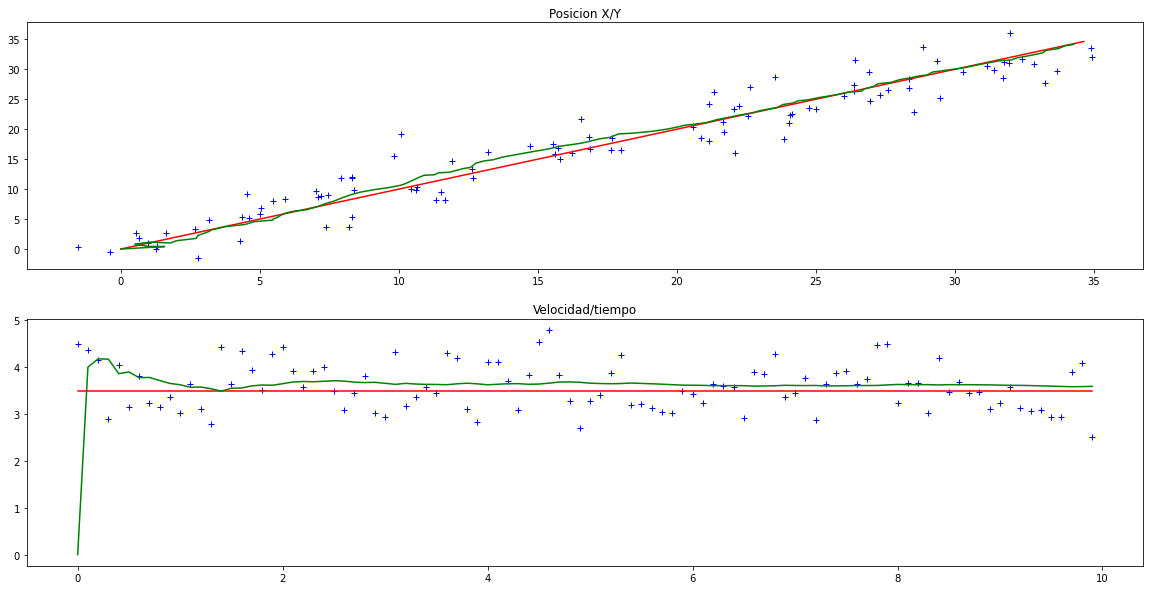

In [94]:
# Mostrando resultados
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(x_medido3x[:,0],x_medido3y[:,0],'+b',x_real3x[:,0],x_real3y[:,0],'r',predictions3x[:,0],predictions3y[:,0],'g')
plt.title('Posicion X/Y')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t3,x_medido3y[:,1],'+b',t3,x_real3y[:,1],'r',t3,predictions3y[:,1],'g')
plt.title('Velocidad/tiempo');

### Movimiento de rotación a velocidad constante

El modelo mostrado en el ejemplo, representa un objeto con movimiento rectilíneo a velocidad constante. Modifique el sistema dado para considerar movimiento circular a velocidad  constante.

Considere las siguientes condiciones: 

*   Radio: 1 m
*   Ángulo inicial: 0 rad
*   Velocidad: 1 rad/s
*   simulación 10 s
*   incremento temporal para la simulación 0.1 s



<font color="red">Generación de los datos del modelo con ruido</font>

In [95]:
w = 1 # Velocidad angular (rad/s)
r = 1 # Radio (m)
t_max4 = 10 # Tiempo (s)
angulo = np.array([0, 1]) # Se resuelve con matrices como en el ejemplo inicial, siendo angulo "=" posicion
error_std4 = np.array([0.8,0.05])

t4 = np.array(np.arange(0,t_max4,0.1))  # Incremento temporal de 0.1s (range no soporta valores decimales, np.arange sí)
angulo_real4 = np.column_stack(([ [1, it] for it in t4 ] @ angulo, [ 1 for it in t4]))
angulo_medido4 = angulo_real4 + np.column_stack((np.random.normal(0,error_std4[0],t_max4*10),np.random.normal(0,error_std4[1],t_max4*10)))

x_real4 = np.cos(angulo_real4[:,0]) # Se convierte el angulo a posicion en cada eje
y_real4 = np.sin(angulo_real4[:,0])

x_medido4 = np.cos(angulo_medido4[:,0])
y_medido4 = np.sin(angulo_medido4[:,0])

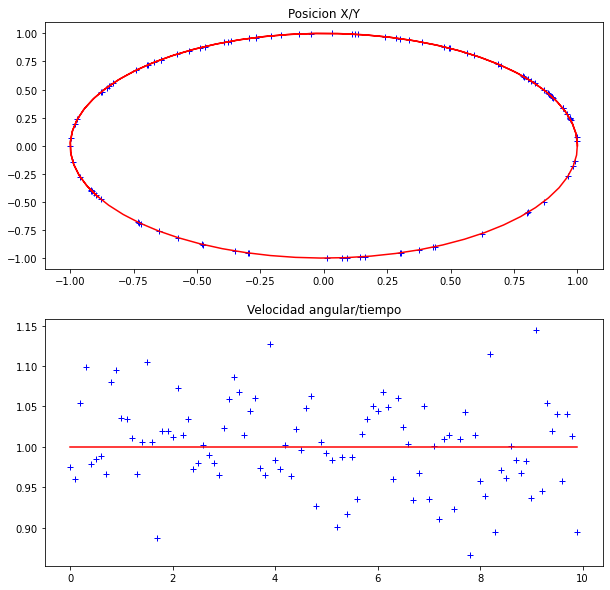

In [96]:
# Representacion de la posicion X/Y y velocidad angular / tiempo
plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(x_medido4,y_medido4,'+b',x_real4,y_real4,'r')
plt.title('Posicion X/Y')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t4,angulo_medido4[:,1],'+b',t4,angulo_real4[:,1],'r')
plt.title('Velocidad angular/tiempo');

<font color="red">Generación del modelo y aplicación del filtro</font>

In [97]:
# Paso del tiempo
dt = 0.1
# Modelo del sistema definido en las matrices
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0],[0,1]])
Q = np.diagflat([0.,0.])
P = np.diagflat([10.,1.])
R = np.diagflat(error_std4)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions4 = np.empty([t_max4*10,2])

# Simulación de la lectura de los sensores
for it, z in enumerate(angulo_medido4):
    x_hat4 = (H @ kf.predict()).T
    predictions4[it,:] = x_hat4
    kf.update(np.array(z).reshape(-1,1))

x_predicho4 = np.cos(predictions4[:,0]) # Se predice el angulo y se convierte a posicion en cada eje
y_predicho4 = np.sin(predictions4[:,0])

<font color="red">Representación de los resultados aquí</font>

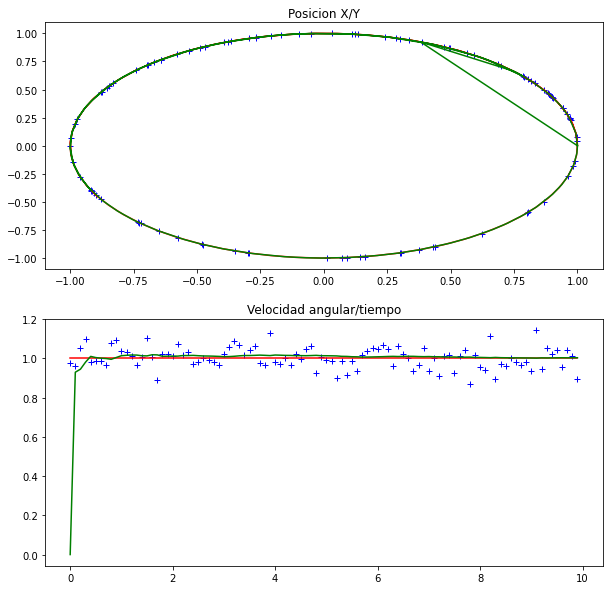

In [98]:
# Mostrando resultados
plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(x_medido4,y_medido4,'+b',x_real4,y_real4,'r',x_predicho4,y_predicho4,'g')
plt.title('Posicion X/Y')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t4,angulo_medido4[:,1],'+b',t4,angulo_real4[:,1],'r',t4,predictions4[:,1],'g')
plt.title('Velocidad angular/tiempo');

# Aumentando el error estandar (poco) se observan grandes cambios en la prediccion de la posicion X/Y

### Fusión de fuentes

El modelo mostrado en el ejemplo, representa un objeto con movimiento rectilíneo a velocidad constante. En dicho modelo, tenemos un único sensor que determina la posición del objeto siendo observado. Modifique el sistema dado para considerar un sistema en el que tenemos 2 sensores independientes (cada uno con su error propio) observando el mismo fenómeno y determine el estado del objeto fusionando la información que aporta cada sensor.

<font color="red">Generación de los datos del modelo con ruido</font>

In [99]:
t_max5 = 150
x_05 = np.array([1,1.5])
error_std51 = np.array([7,0.4]) # Error aleatorio 1
error_std52 = np.array([5,0.2]) # Error aleatorio 2

t5 = np.array(range(t_max5))
x_real5 = np.column_stack(([ [1, it] for it in t ] @ x_0, [ 1 for it in t]))
x_medido51 = x_real5 + np.column_stack((np.random.normal(0,error_std51[0],t_max5),np.random.normal(0,error_std51[1],t_max5)))
x_medido52 = x_real5 + np.column_stack((np.random.normal(0,error_std52[0],t_max5),np.random.normal(0,error_std52[1],t_max5)))

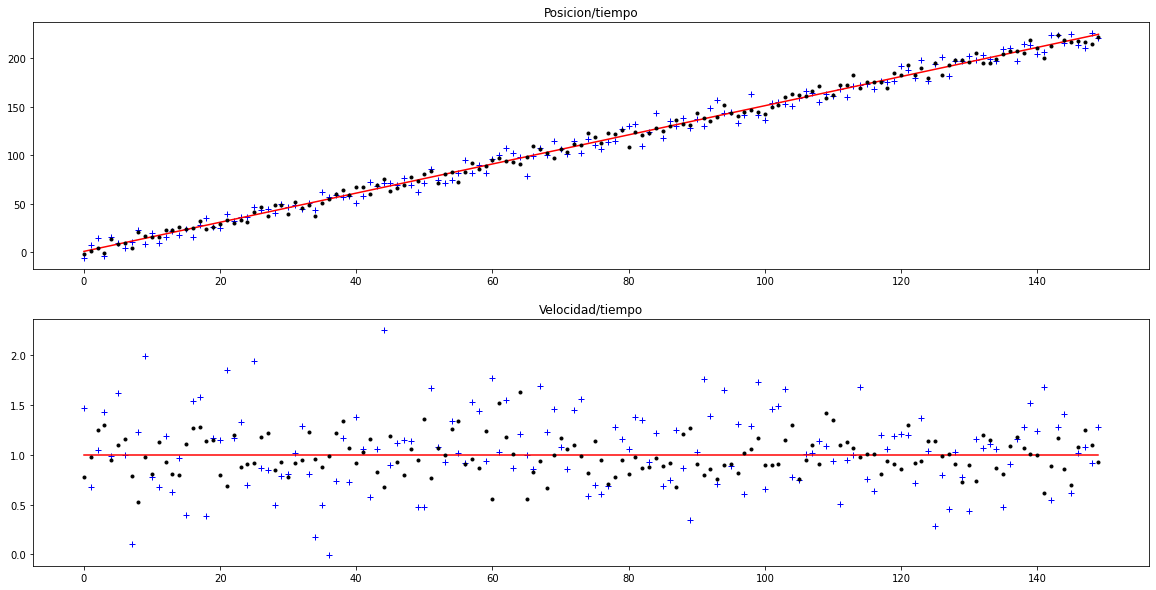

In [100]:
# Sensor 1 = cruces azules. Sensor 2 = circulos negros
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(t5,x_medido51[:,0],'+b',t5,x_real5[:,0],'r',t5,x_medido52[:,0],'.k')
plt.title('Posicion/tiempo')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t5,x_medido51[:,1],'+b',t5,x_real5[:,1],'r',t5,x_medido52[:,1],'.k')
plt.title('Velocidad/tiempo');

<font color="red">Generación del modelo y aplicación del filtro</font>

In [101]:
# Paso del tiempo
dt = 1.0
# Modelo del sistema definido en las matrices
F = np.array([[1, dt], [0, 1]])
H = np.array([[1, 0],[0,1]])
Q = np.diagflat([0.,0.])
P = np.diagflat([100.,2.])
R = np.diagflat(error_std)

# creación del motor de filtrado e inicialización del modelo
kf = KalmanFilter(F = F, H = H, Q = Q, P = P, R = R)

# reserva de espacio para las predicciones
predictions5 = np.empty([t_max5,2])

# Se ha optado por realizar la prediccion con la media aritmetica de los valores medidos
# Tambien se podria hacer una prediccion para cada medida y despues la media de dichas predicciones
x_medido5 = (x_medido51 + x_medido52) / 2

# Simulación de la lectura del sensor 1
for it, z in enumerate(x_medido5):
    x_hat5 = (H @ kf.predict()).T
    predictions5[it,:] = x_hat5
    kf.update(np.array(z).reshape(-1,1))

<font color="red">Representación de los resultados aquí</font>

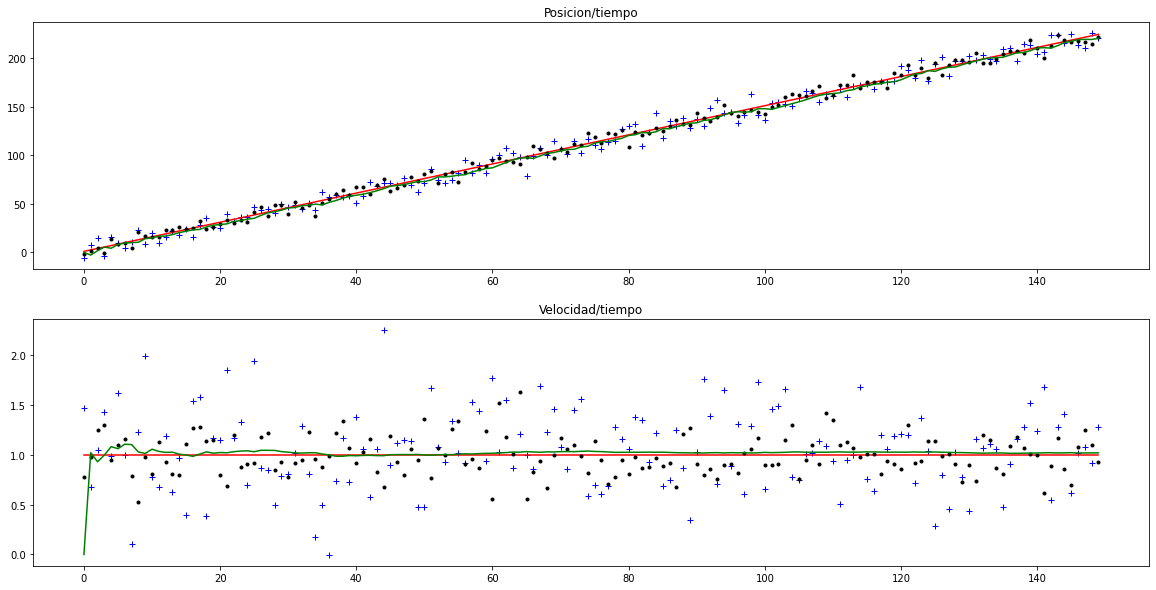

In [102]:
# Mostrando resultados
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 1, 1)
ax1.plot(t5,x_medido51[:,0],'+b',t5,x_real5[:,0],'r',t5,x_medido52[:,0],'.k',t5,predictions5[:,0],'g')
plt.title('Posicion/tiempo')
ax2=plt.subplot(2, 1, 2)
ax2.plot(t5,x_medido51[:,1],'+b',t5,x_real5[:,1],'r',t5,x_medido52[:,1],'.k',t5,predictions5[:,1],'g')
plt.title('Velocidad/tiempo');